In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import os

from sklearn import preprocessing
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

from datetime import date
import holidays
us_holidays = holidays.UnitedStates()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Feather data

In [5]:
# #####
# # weather shift
# shift_hour = 1
# ######

# train_df = pd.read_csv('Data/train.csv')
# weather_train_df = pd.read_csv('Data/weather_train.csv')
# test_df = pd.read_csv('Data/test.csv')
# weather_test_df = pd.read_csv('Data/weather_test.csv')
# building_meta_df = pd.read_csv('Data/building_metadata.csv')
# # sample_submission = pd.read_csv(os.path.join(root, 'sample_submission.csv'))

# train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
# test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
# weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
# weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

# cols = ['air_temperature', 'cloud_coverage',
#        'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
#        'wind_direction', 'wind_speed']
# for col in cols:
#     weather_train_df[col+'_lag'] = weather_train_df[col].shift(shift_hour)
#     weather_test_df[col+'_lag'] = weather_test_df[col].shift(shift_hour)

# train_df.to_feather('Data/train.feather')
# test_df.to_feather('Data/test.feather')
# weather_train_df.to_feather('Data/weather_train.feather')
# weather_test_df.to_feather('Data/weather_test.feather')
# building_meta_df.to_feather('Data/building_metadata.feather')
# # sample_submission.to_feather('sample_submission.feather')

In [6]:
# train_df = pd.read_feather('Data/train.feather')
# weather_train_df = pd.read_feather('Data/weather_train.feather')
# test_df = pd.read_feather('Data/test.feather')
# weather_test_df = pd.read_feather('Data/weather_test.feather')
# building_meta_df = pd.read_feather('Data/building_metadata.feather')

In [7]:
# %%time
# train_df = train_df.merge(building_meta_df, left_on = "building_id", right_on = "building_id", how = "left")
# train_df = train_df.merge(weather_train_df, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")
# train_df.to_feather('Data/train_joined.feather')

Wall time: 15.2 s


In [21]:
%%time
train = pd.read_feather('Data/train_joined.feather') # for changing features
# train = pd.read_feather('Data/train_joined_processed.feather')

Wall time: 13.6 s


In [22]:
%%time
le = preprocessing.LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use'])

move = ['meter_reading', 'timestamp'] + [x for x in train.columns if x not in ['meter_reading', 'timestamp']]
train = train[move]

# mask =(train['site_id']==0) & (train['timestamp'] < '2016-06-01')
# train = train[~mask]

## this may take mins
# train['date_month'] = train['timestamp'].map(lambda x: x.month)
# train['date_day'] = train['timestamp'].map(lambda x: x.day)
# train['iso_week'] = train['timestamp'].map(lambda x: x.isocalendar()[1])
# train['iso_weekend'] = train['timestamp'].map(lambda x: x.isocalendar()[2])
# train['hour'] = train['timestamp'].map(lambda x: x.hour)
# train['holidays'] = train['timestamp'].map(lambda x: 1 if x in us_holidays else 0)

Wall time: 5.76 s


In [10]:
# train = train.drop(['year_built', 'floor_count', 
#                     'precip_depth_1_hr', 'cloud_coverage', 'sea_level_pressure', 'wind_direction',
#                    'precip_depth_1_hr_lag', 'cloud_coverage_lag', 
#                     'sea_level_pressure_lag', 'wind_direction_lag'], axis=1)
# train = train.dropna()
# train.isnull().sum()/train.shape[0]

meter_reading          0.0
timestamp              0.0
building_id            0.0
meter                  0.0
site_id                0.0
primary_use            0.0
square_feet            0.0
air_temperature        0.0
dew_temperature        0.0
wind_speed             0.0
air_temperature_lag    0.0
dew_temperature_lag    0.0
wind_speed_lag         0.0
dtype: float64

## Create raw data for AutoML

In [23]:
train.shape

(20216100, 23)

In [24]:
cols = ['meter_reading', 'building_id', 'meter', 'site_id',
       'primary_use', 'square_feet', 'air_temperature', 'dew_temperature',
       'wind_speed', 'year_built', 'floor_count', 
        'precip_depth_1_hr', 'cloud_coverage', 'sea_level_pressure', 'wind_direction']
train_sub = train[cols]
# y = train.iloc[:,0]
# X_train, X_test, __, __ = train_test_split(X, y, test_size=0.2, random_state=33)

In [25]:
train_sub.shape

(20216100, 15)

In [26]:
train_sub.head()

,meter_reading,building_id,meter,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,year_built,floor_count,precip_depth_1_hr,cloud_coverage,sea_level_pressure,wind_direction
0,0.0,0,0,0,0,7432,25.0,20.0,0.0,2008.0,NaN,NaN,6.0,1019.7,0.0
1,0.0,1,0,0,0,2720,25.0,20.0,0.0,2004.0,NaN,NaN,6.0,1019.7,0.0
2,0.0,2,0,0,0,5376,25.0,20.0,0.0,1991.0,NaN,NaN,6.0,1019.7,0.0
3,0.0,3,0,0,0,23685,25.0,20.0,0.0,2002.0,NaN,NaN,6.0,1019.7,0.0
4,0.0,4,0,0,0,116607,25.0,20.0,0.0,1975.0,NaN,NaN,6.0,1019.7,0.0


In [27]:
%%time
train_sub.to_csv('raw_automl.csv', index=False)

Wall time: 3min 32s


In [20]:
X_train.to_csv('raw_train_automl.csv', index=False)
X_test.to_csv('raw_validation_automl.csv', index=False)

Wall time: 0 ns


In [18]:
check = pd.read_csv('raw_train_automl.csv')

In [19]:
check.head()

,Unnamed: 0,meter_reading,building_id,meter,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed
0,12971355,101.000,587,0,4,13,53234,17.2,12.8,6.2
1,19232731,501.644,924,1,9,1,252268,7.8,3.9,2.1
2,5731617,370.817,934,1,9,1,170607,18.3,17.8,3.1
3,2135001,20.075,1418,0,15,4,41302,2.8,-4.4,4.1
4,16846802,218.299,1150,0,13,6,196043,16.7,6.1,3.6


## A simple model

In [3]:
train.head()

,meter_reading,timestamp,building_id,meter,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,air_temperature_lag,dew_temperature_lag,wind_speed_lag,date_month,date_day,iso_week,iso_weekend,hour,holidays
0,23.3036,2016-01-01,105,0,1,0,50623,3.8,2.4,3.1,20.6,10.0,0.0,1,1,53,5,0,1
1,0.3746,2016-01-01,106,0,1,0,5374,3.8,2.4,3.1,20.6,10.0,0.0,1,1,53,5,0,1
2,0.0000,2016-01-01,106,3,1,0,5374,3.8,2.4,3.1,20.6,10.0,0.0,1,1,53,5,0,1
3,175.1840,2016-01-01,107,0,1,0,97532,3.8,2.4,3.1,20.6,10.0,0.0,1,1,53,5,0,1
4,91.2653,2016-01-01,108,0,1,0,81580,3.8,2.4,3.1,20.6,10.0,0.0,1,1,53,5,0,1


In [21]:
train.shape

(19588243, 19)

In [64]:
%%time
X = train.iloc[:,2:]
y = train.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# locate categorical variables
cat_variables = ['building_id', 'meter', 'site_id', 'primary_use', 'date_month', 'date_day',
                'iso_week', 'iso_weekend', 'hour', 'holidays']
cat_variables_loc = list()
for var in cat_variables:
    cat_variables_loc.append(X_train.columns.get_loc(var))

bst2 = lgb.LGBMRegressor(n_estimators = 500)
bst2.fit(X_train.values, y_train.values, categorical_feature=cat_variables_loc)

prediction_on_X_train = bst2.predict(X_train)
prediction_on_X_train = pd.Series(prediction_on_X_train)
prediction_on_X_train[prediction_on_X_train<0] = 0
print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

prediction_on_X_test = bst2.predict(X_test)
prediction_on_X_test = pd.Series(prediction_on_X_test)
prediction_on_X_test[prediction_on_X_test<0] = 0
print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 11, 12, 13, 14, 15, 16]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train:  1.7997460444617523
test:  1.799824508886102
Wall time: 3min 47s


Text(0.5, 1.0, 'Gradient Boosting Model Importance')

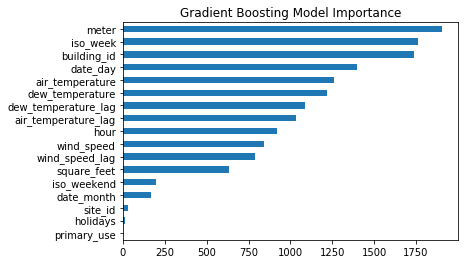

In [65]:
importance = pd.Series(bst2.feature_importances_, index=X_train.columns)
importance.sort_values().plot.barh()        
plt.title('Gradient Boosting Model Importance')

## Combine Gab's feature using feather file

In [20]:
# %%time
# #####
# # weather shift
# shift_hour = 1
# ######

# weather_train_df = pd.read_csv('Data/weather_train_processed.csv')
# weather_test_df = pd.read_csv('Data/weather_test_processed.csv')

# weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
# weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

# ## Don't need lag variable for now
# # cols = ['air_temperature', 'cloud_coverage',
# #        'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
# #        'wind_direction', 'wind_speed']
# # for col in cols:
# #     weather_train_df[col+'_lag'] = weather_train_df[col].shift(shift_hour)
# #     weather_test_df[col+'_lag'] = weather_test_df[col].shift(shift_hour)

# weather_train_df.to_feather('Data/weather_train_processed.feather')
# weather_test_df.to_feather('Data/weather_test_processed.feather')

Wall time: 856 ms


In [22]:
# train_df = pd.read_feather('Data/train.feather')
# weather_train_df = pd.read_feather('Data/weather_train_processed.feather')
# test_df = pd.read_feather('Data/test.feather')
# weather_test_df = pd.read_feather('Data/weather_test_processed.feather')
# building_meta_df = pd.read_feather('Data/building_metadata.feather')

In [23]:
# %%time
# train_df = train_df.merge(building_meta_df, left_on = "building_id", right_on = "building_id", how = "left")
# train_df = train_df.merge(weather_train_df, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")
# train_df.to_feather('Data/train_joined_processed.feather')

Wall time: 27.2 s


In [24]:
train_df.shape

(20216100, 22)

In [25]:
## take off site 0 weried data

mask =(train_df['site_id']==0) & (train_df['timestamp'] < '2016-06-01')
train_df = train_df[~mask]

In [26]:
train_df.shape

(19790105, 22)

In [29]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,wind_direction cat,precipitation,precipitation sign,wind_speed_log
103,105,0,2016-01-01,23.3036,1,Education,50623,NaN,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,Southwest,Unknown,Unknown,1.410987
104,106,0,2016-01-01,0.3746,1,Education,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,Southwest,Unknown,Unknown,1.410987
105,106,3,2016-01-01,0.0000,1,Education,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,Southwest,Unknown,Unknown,1.410987
106,107,0,2016-01-01,175.1840,1,Education,97532,2005.0,10.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,Southwest,Unknown,Unknown,1.410987
107,108,0,2016-01-01,91.2653,1,Education,81580,1913.0,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,Southwest,Unknown,Unknown,1.410987


In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19790105 entries, 103 to 20216099
Data columns (total 22 columns):
building_id           int64
meter                 int64
timestamp             datetime64[ns]
meter_reading         float64
site_id               int64
primary_use           object
square_feet           int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
month                 float64
day                   float64
wind_direction cat    object
precipitation         object
precipitation sign    object
wind_speed_log        float64
dtypes: datetime64[ns](1), float64(13), int64(4), object(4)
memory usage: 3.4+ GB


In [33]:
# cat_variables = ['building_id', 'meter', 'site_id', 'primary_use', 'date_month', 'date_day',
#                 'iso_week', 'iso_weekend', 'hour', 'holidays']
cat_need_encode = ['primary_use', 'wind_direction cat', 'precipitation', 'precipitation sign']

In [50]:
## process nan value in cat variable

# train_df['wind_direction cat'][train_df['wind_direction cat'].isna()] = 'No Wind'
# train_df['precipitation'][train_df['precipitation'].isna()] = 'Unknown'
# train_df['precipitation sign'][train_df['precipitation sign'].isna()] = 'Unknown'
# np.sum(train_df['precipitation sign'].isna())

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0

In [51]:
%%time
for var in cat_need_encode:
    print(var)
    le = preprocessing.LabelEncoder()
    train_df[var] = le.fit_transform(train_df[var])

primary_use
wind_direction cat
precipitation
precipitation sign
Wall time: 9.16 s


In [52]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,wind_direction cat,precipitation,precipitation sign,wind_speed_log
103,105,0,2016-01-01,23.3036,1,0,50623,NaN,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987
104,106,0,2016-01-01,0.3746,1,0,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987
105,106,3,2016-01-01,0.0000,1,0,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987
106,107,0,2016-01-01,175.1840,1,0,97532,2005.0,10.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987
107,108,0,2016-01-01,91.2653,1,0,81580,1913.0,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987


#### Add 
1. weekend
2. holday 
3. hour

In [53]:
train_df['iso_weekend'] = train_df['timestamp'].map(lambda x: x.isocalendar()[2])
train_df['hour'] = train_df['timestamp'].map(lambda x: x.hour)
train_df['holidays'] = train_df['timestamp'].map(lambda x: 1 if x in us_holidays else 0)

#### Changing order

In [54]:
move = ['meter_reading', 'timestamp'] + [x for x in train_df.columns if x not in ['meter_reading', 'timestamp']]
train_df = train_df[move]

#### Save to processed_processed

In [57]:
train_df = train_df.reset_index(drop=True)

In [58]:
train_df.to_feather('Data/train_joined_processed_processed.feather')

In [59]:
train_df.head()

,meter_reading,timestamp,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,wind_direction cat,precipitation,precipitation sign,wind_speed_log,iso_weekend,hour,holidays
0,23.3036,2016-01-01,105,0,1,0,50623,NaN,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987,5,0,1
1,0.3746,2016-01-01,106,0,1,0,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987,5,0,1
2,0.0000,2016-01-01,106,3,1,0,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987,5,0,1
3,175.1840,2016-01-01,107,0,1,0,97532,2005.0,10.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987,5,0,1
4,91.2653,2016-01-01,108,0,1,0,81580,1913.0,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,1.0,1.0,7,1,2,1.410987,5,0,1


## Simple model on Gab's feature

In [62]:
%%time
X = train_df.iloc[:,2:]
y = train_df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# locate categorical variables
cat_variables = ['building_id', 'meter', 'site_id', 'primary_use', 'month', 'day',
                'iso_weekend', 'hour', 'holidays',
                'wind_direction cat', 'precipitation', 'precipitation sign']

cat_variables_loc = list()
for var in cat_variables:
    cat_variables_loc.append(train_df.columns.get_loc(var))

bst = lgb.LGBMRegressor(n_estimators = 750)
bst.fit(X_train.values, y_train.values, categorical_feature=cat_variables_loc)

prediction_on_X_train = bst.predict(X_train)
prediction_on_X_train = pd.Series(prediction_on_X_train)
prediction_on_X_train[prediction_on_X_train<0] = 0
print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

prediction_on_X_test = bst.predict(X_test)
prediction_on_X_test = pd.Series(prediction_on_X_test)
prediction_on_X_test[prediction_on_X_test<0] = 0
print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 3, 4, 5, 16, 17, 18, 19, 20, 22, 23, 24]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train:  1.8170202577046102
test:  1.8169871394811132
Wall time: 8min 2s


Text(0.5, 1.0, 'Gradient Boosting Model Importance')

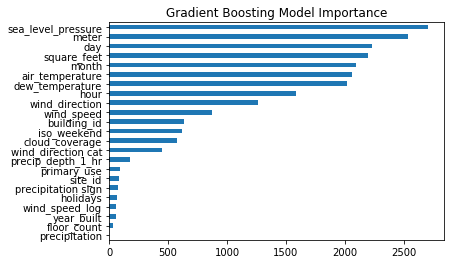

In [63]:
importance = pd.Series(bst.feature_importances_, index=X_train.columns)
importance.sort_values().plot.barh()        
plt.title('Gradient Boosting Model Importance')

## Subset data

In [66]:
X = train_df.iloc[:,2:]
y = train_df.iloc[:,0]
X_sub, X_test, y_sub, y_test = train_test_split(X, y, test_size=0.8, random_state=33)

In [ ]:
# remaining_col = ['building_id', 'meter', 'site_id', 'primary_use', 'square_feet',
#        'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
#        'dew_temperature', 'sea_level_pressure',
#        'wind_direction', 'wind_speed', 'month', 'day', 'wind_direction cat',
#        'precipitation', 'precipitation sign', 'wind_speed_log', 'iso_weekend',
#        'hour', 'holidays']
# # X_sub

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.5, random_state=33)

In [68]:
%%time
cat_variables = ['building_id', 'meter', 'site_id', 'primary_use', 'month', 'day',
                'iso_weekend', 'hour', 'holidays',
                'wind_direction cat', 'precipitation', 'precipitation sign']

cat_variables_loc = list()
for var in cat_variables:
    cat_variables_loc.append(train_df.columns.get_loc(var))

bst3 = lgb.LGBMRegressor(n_estimators = 750)
bst3.fit(X_train.values, y_train.values, categorical_feature=cat_variables_loc)

prediction_on_X_train = bst3.predict(X_train)
prediction_on_X_train = pd.Series(prediction_on_X_train)
prediction_on_X_train[prediction_on_X_train<0] = 0
print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

prediction_on_X_test = bst3.predict(X_test)
prediction_on_X_test = pd.Series(prediction_on_X_test)
prediction_on_X_test[prediction_on_X_test<0] = 0
print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 3, 4, 5, 16, 17, 18, 19, 20, 22, 23, 24]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train:  2.046539837279741
test:  2.0593426495596536


In [80]:
remaining_col = [col for col in X_train.columns if col != 'sea_level_pressure']

In [82]:
X_sub = X_sub[remaining_col]
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.5, random_state=33)

In [83]:
%%time
cat_variables = ['building_id', 'meter', 'site_id', 'primary_use', 'month', 'day',
                'iso_weekend', 'hour', 'holidays',
                'wind_direction cat', 'precipitation', 'precipitation sign']

cat_variables_loc = list()
for var in cat_variables:
    cat_variables_loc.append(train_df.columns.get_loc(var))

bst3 = lgb.LGBMRegressor(n_estimators = 750)
bst3.fit(X_train.values, y_train.values, categorical_feature=cat_variables_loc)

prediction_on_X_train = bst3.predict(X_train)
prediction_on_X_train = pd.Series(prediction_on_X_train)
prediction_on_X_train[prediction_on_X_train<0] = 0
print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

prediction_on_X_test = bst3.predict(X_test)
prediction_on_X_test = pd.Series(prediction_on_X_test)
prediction_on_X_test[prediction_on_X_test<0] = 0
print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 3, 4, 5, 16, 17, 18, 19, 20, 22, 23, 24]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train:  1.9378068107584805
test:  1.948162469307961
Wall time: 1min


Text(0.5, 1.0, 'Gradient Boosting Model Importance')

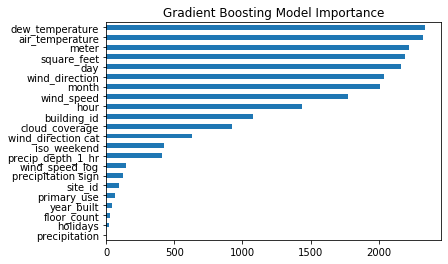

In [84]:
importance = pd.Series(bst3.feature_importances_, index=X_train.columns)
importance.sort_values().plot.barh()        
plt.title('Gradient Boosting Model Importance')

## Neuro Net

## Nov 14th Note
1. add holiday features and lag features
2. comparable data for site 0 = site 8 ---- doesn't work
3. try -- model by building except for site 0  ---- doesn't work
4. try -- model by site

#### locate the sites 

https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature

#### 1.08 by meter 

https://www.kaggle.com/yamsam/new-ucf-starter-kernel

max, mean, min, std of the specific building historically

#### Leak data

https://www.kaggle.com/gunesevitan/ashrae-ucf-spider-and-eda-full-test-labels

#### Very clean and easy

https://www.kaggle.com/rohanrao/ashrae-half-and-half

#### Super clean

https://www.kaggle.com/kailex/ac-dc


## Take out cloud_coverage, precip_depth_1_hr, wind_direction, and  sea_level_pressure for now, and drop some missing values

In [3]:
# train = train.drop(['year_built', 'floor_count', 
#                     'precip_depth_1_hr', 'cloud_coverage', 'sea_level_pressure', 'wind_direction',
#                    'precip_depth_1_hr_lag', 'cloud_coverage_lag', 
#                     'sea_level_pressure_lag', 'wind_direction_lag'], axis=1)
# train = train.dropna()
# train.isnull().sum()/train.shape[0]

building_id            0.0
meter                  0.0
timestamp              0.0
meter_reading          0.0
site_id                0.0
primary_use            0.0
square_feet            0.0
air_temperature        0.0
dew_temperature        0.0
wind_speed             0.0
air_temperature_lag    0.0
dew_temperature_lag    0.0
wind_speed_lag         0.0
dtype: float64

## Preprocess
1. Label primary_use 
2. move y to the first column
3. Remove first 5 months in site 0
4. Add month, week day, day, hour, holidays

In [4]:
# %%time
# le = preprocessing.LabelEncoder()
# train['primary_use'] = le.fit_transform(train['primary_use'])

# move = ['meter_reading', 'timestamp'] + [x for x in train.columns if x not in ['meter_reading', 'timestamp']]
# train = train[move]

# mask =(train['site_id']==0) & (train['timestamp'] < '2016-06-01')
# train = train[~mask]

# ## this may take mins
# train['date_month'] = train['timestamp'].map(lambda x: x.month)
# train['date_day'] = train['timestamp'].map(lambda x: x.day)
# train['iso_week'] = train['timestamp'].map(lambda x: x.isocalendar()[1])
# train['iso_weekend'] = train['timestamp'].map(lambda x: x.isocalendar()[2])
# train['hour'] = train['timestamp'].map(lambda x: x.hour)
# train['holidays'] = train['timestamp'].map(lambda x: 1 if x in us_holidays else 0)

Wall time: 3min 52s


In [9]:
# train = train.reset_index(drop=True)
# train.to_feather('Data/train_joined_processed.feather')

## Model code

In [ ]:
# %%time
# X = train.iloc[:,2:]
# y = train.iloc[:,0]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# bst = lgb.LGBMRegressor(n_estimators = 500)
# bst.fit(X_train.values, y_train.values)

# prediction_on_X_train = bst.predict(X_train)
# prediction_on_X_train = pd.Series(prediction_on_X_train)
# prediction_on_X_train[prediction_on_X_train<0] = 0
# print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

# prediction_on_X_test = bst.predict(X_test)
# prediction_on_X_test = pd.Series(prediction_on_X_test)
# prediction_on_X_test[prediction_on_X_test<0] = 0
# print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

## Model on transformed y

In [9]:
# %%time
# X = train.iloc[:,2:]
# y = train.iloc[:,0].map(lambda x: np.log(x+1))
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

Wall time: 27 s


In [10]:
# %%time
# bst = lgb.LGBMRegressor(n_estimators = 500)
# bst.fit(X_train.values, y_train.values)

Wall time: 3min 26s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
# %%time
# prediction_on_X_train = bst.predict(X_train)
# prediction_on_X_train = pd.Series(prediction_on_X_train)
# prediction_on_X_train[prediction_on_X_train<0] = 0
# prediction_on_X_train = prediction_on_X_train.map(lambda x: np.exp(x)-1)
# print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

# prediction_on_X_test = bst.predict(X_test)
# prediction_on_X_test = pd.Series(prediction_on_X_test)
# prediction_on_X_test[prediction_on_X_test<0] = 0
# prediction_on_X_test = prediction_on_X_test.map(lambda x: np.exp(x)-1)
# print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

train:  2.9720583404140104
test:  2.971924446128734
Wall time: 1min 49s


## Randomly train a model for a building
My hypothesis is: if we train model for each building, then we can improve performance significantly.

To test my hypothesis, I'm going to randomly choose some buildings and build models on each of them.

In [10]:
building_list = train['building_id'].drop_duplicates()
building_list[-5:]

11556727    567
12463713    621
12853524    591
13408420    783
18463195    403
Name: building_id, dtype: int64

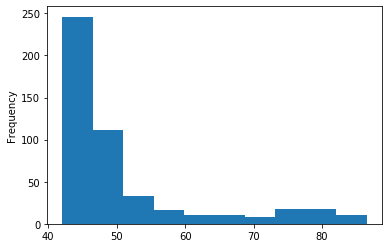

In [11]:
sample = train[train['building_id']==403]
sample['meter_reading'].plot.hist()

In [32]:
# %%time
# X = sample.iloc[:,2:]
# y = sample.iloc[:,0]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# bst = lgb.LGBMRegressor(n_estimators = 100)
# bst.fit(X_train.values, y_train.values)

# prediction_on_X_train = bst.predict(X_train)
# prediction_on_X_train = pd.Series(prediction_on_X_train)
# prediction_on_X_train[prediction_on_X_train<0] = 0
# print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

# prediction_on_X_test = bst.predict(X_test)
# prediction_on_X_test = pd.Series(prediction_on_X_test)
# prediction_on_X_test[prediction_on_X_test<0] = 0
# print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

# #building 403
# #train:  0.019758227944799908
# #test:  0.03989536278172967

train:  0.019758227944799908
test:  0.03989536278172967
Wall time: 63.8 ms


#### Variables: lag terms, holiday see if better
Yes, 0.03989 vs 0.04307 on test set

In [12]:
%%time
X = sample.iloc[:,2:]
y = sample.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

bst = lgb.LGBMRegressor(n_estimators = 100)
bst.fit(X_train.values, y_train.values)

prediction_on_X_train = bst.predict(X_train)
prediction_on_X_train = pd.Series(prediction_on_X_train)
prediction_on_X_train[prediction_on_X_train<0] = 0
print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

prediction_on_X_test = bst.predict(X_test)
prediction_on_X_test = pd.Series(prediction_on_X_test)
prediction_on_X_test[prediction_on_X_test<0] = 0
print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

train:  0.019321215868780214
test:  0.04307237046245445
Wall time: 101 ms


## Try train a set of model

In [4]:
import random
# samples = random.sample(set(building_list), 5)
# print(samples)
samples = [1058, 797, 1246, 889, 1190]
# samples = range(0,105)

In [28]:
%%time
y_train_list = pd.Series()
y_test_list = pd.Series()

prediction_train = pd.Series()
prediction_test = pd.Series()

for sample in samples: 
    sample_df = train[train['building_id']==sample]
    X = sample_df.iloc[:,2:]
    y = sample_df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    
    bst = lgb.LGBMRegressor(n_estimators = 100)
    bst.fit(X_train.values, y_train.values)
    
    prediction_on_X_train = bst.predict(X_train)
    prediction_on_X_train = pd.Series(prediction_on_X_train)
    prediction_on_X_train[prediction_on_X_train<0] = 0

    prediction_on_X_test = bst.predict(X_test)
    prediction_on_X_test = pd.Series(prediction_on_X_test)
    prediction_on_X_test[prediction_on_X_test<0] = 0
    
    y_train_list = pd.concat([y_train_list, y_train])
    y_test_list = pd.concat([y_test_list, y_test])

    prediction_train = pd.concat([prediction_train, prediction_on_X_train])
    prediction_test = pd.concat([prediction_test, prediction_on_X_test])

print('train: ', np.sqrt(mean_squared_log_error( y_train_list, prediction_train)))
print('test: ', np.sqrt(mean_squared_log_error( y_test_list, prediction_test)))

train:  0.4565518911296274
test:  0.4827336274457721
Wall time: 20.1 s


## Try to save and read a set of models

In [11]:
path = 'models3'

for sample in samples: 
    sample_df = train[train['building_id']==sample]
    X = sample_df.iloc[:,2:]
    y = sample_df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    
    bst = lgb.LGBMRegressor(n_estimators = 1000, subsample=0.8)
    bst.fit(X_train.values, y_train.values, early_stopping_rounds = 20 ,
           eval_set=[(X_test.values, y_test.values)], verbose = False)
    
    bst.booster_.save_model(path + '/model{}.txt'.format(sample))

y_train_list = pd.Series()
y_test_list = pd.Series()

prediction_train = pd.Series()
prediction_test = pd.Series()

for sample in samples: 
    sample_df = train[train['building_id']==sample]
    X = sample_df.iloc[:,2:]
    y = sample_df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    
    bst = lgb.Booster(model_file = path + '/model{}.txt'.format(sample))
    
    prediction_on_X_train = bst.predict(X_train)
    prediction_on_X_train = pd.Series(prediction_on_X_train)
    prediction_on_X_train[prediction_on_X_train<0] = 0

    prediction_on_X_test = bst.predict(X_test)
    prediction_on_X_test = pd.Series(prediction_on_X_test)
    prediction_on_X_test[prediction_on_X_test<0] = 0
    
    y_train_list = pd.concat([y_train_list, y_train])
    y_test_list = pd.concat([y_test_list, y_test])

    prediction_train = pd.concat([prediction_train, prediction_on_X_train])
    prediction_test = pd.concat([prediction_test, prediction_on_X_test])

print('train: ', np.sqrt(mean_squared_log_error( y_train_list, prediction_train)))
print('test: ', np.sqrt(mean_squared_log_error( y_test_list, prediction_test)))

[1]	valid_0's l2: 381.303
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 328.156
[3]	valid_0's l2: 284.19
[4]	valid_0's l2: 249.489
[5]	valid_0's l2: 219.91
[6]	valid_0's l2: 196.306
[7]	valid_0's l2: 176.312
[8]	valid_0's l2: 160.055
[9]	valid_0's l2: 146.6
[10]	valid_0's l2: 135.307
[11]	valid_0's l2: 124.068
[12]	valid_0's l2: 115.989
[13]	valid_0's l2: 108.506
[14]	valid_0's l2: 102.725
[15]	valid_0's l2: 97.1824
[16]	valid_0's l2: 92.9378
[17]	valid_0's l2: 89.3874
[18]	valid_0's l2: 85.9383
[19]	valid_0's l2: 83.1584
[20]	valid_0's l2: 80.3673
[21]	valid_0's l2: 77.5291
[22]	valid_0's l2: 75.3031
[23]	valid_0's l2: 73.3988
[24]	valid_0's l2: 71.5048
[25]	valid_0's l2: 70.0961
[26]	valid_0's l2: 68.814
[27]	valid_0's l2: 67.7579
[28]	valid_0's l2: 66.6062
[29]	valid_0's l2: 65.3268
[30]	valid_0's l2: 63.241
[31]	valid_0's l2: 61.4423
[32]	valid_0's l2: 59.5497
[33]	valid_0's l2: 58.8736
[34]	valid_0's l2: 57.6279
[35]	valid_0's l2: 56.275
[36]	valid

[349]	valid_0's l2: 20.7196
[350]	valid_0's l2: 20.7173
[351]	valid_0's l2: 20.7053
[352]	valid_0's l2: 20.687
[353]	valid_0's l2: 20.6699
[354]	valid_0's l2: 20.6645
[355]	valid_0's l2: 20.6558
[356]	valid_0's l2: 20.6396
[357]	valid_0's l2: 20.6424
[358]	valid_0's l2: 20.6539
[359]	valid_0's l2: 20.6502
[360]	valid_0's l2: 20.6462
[361]	valid_0's l2: 20.6444
[362]	valid_0's l2: 20.6247
[363]	valid_0's l2: 20.625
[364]	valid_0's l2: 20.6027
[365]	valid_0's l2: 20.5809
[366]	valid_0's l2: 20.5336
[367]	valid_0's l2: 20.5306
[368]	valid_0's l2: 20.5237
[369]	valid_0's l2: 20.5085
[370]	valid_0's l2: 20.4728
[371]	valid_0's l2: 20.4608
[372]	valid_0's l2: 20.434
[373]	valid_0's l2: 20.4474
[374]	valid_0's l2: 20.4468
[375]	valid_0's l2: 20.4442
[376]	valid_0's l2: 20.4393
[377]	valid_0's l2: 20.4321
[378]	valid_0's l2: 20.4136
[379]	valid_0's l2: 20.3721
[380]	valid_0's l2: 20.3715
[381]	valid_0's l2: 20.3802
[382]	valid_0's l2: 20.3745
[383]	valid_0's l2: 20.3726
[384]	valid_0's l2: 20.

[117]	valid_0's l2: 171455
[118]	valid_0's l2: 171022
[119]	valid_0's l2: 170965
[120]	valid_0's l2: 170831
[121]	valid_0's l2: 170589
[122]	valid_0's l2: 170484
[123]	valid_0's l2: 170137
[124]	valid_0's l2: 169795
[125]	valid_0's l2: 169758
[126]	valid_0's l2: 169425
[127]	valid_0's l2: 169210
[128]	valid_0's l2: 168888
[129]	valid_0's l2: 168336
[130]	valid_0's l2: 168171
[131]	valid_0's l2: 168073
[132]	valid_0's l2: 167992
[133]	valid_0's l2: 167756
[134]	valid_0's l2: 167179
[135]	valid_0's l2: 167047
[136]	valid_0's l2: 166637
[137]	valid_0's l2: 166498
[138]	valid_0's l2: 166403
[139]	valid_0's l2: 166236
[140]	valid_0's l2: 166218
[141]	valid_0's l2: 165917
[142]	valid_0's l2: 165747
[143]	valid_0's l2: 165531
[144]	valid_0's l2: 165585
[145]	valid_0's l2: 165533
[146]	valid_0's l2: 165166
[147]	valid_0's l2: 165068
[148]	valid_0's l2: 164750
[149]	valid_0's l2: 164461
[150]	valid_0's l2: 164323
[151]	valid_0's l2: 164257
[152]	valid_0's l2: 164117
[153]	valid_0's l2: 163844
[

[493]	valid_0's l2: 134892
[494]	valid_0's l2: 134943
[495]	valid_0's l2: 134877
[496]	valid_0's l2: 134860
[497]	valid_0's l2: 134853
[498]	valid_0's l2: 134760
[499]	valid_0's l2: 134762
[500]	valid_0's l2: 134741
[501]	valid_0's l2: 134690
[502]	valid_0's l2: 134721
[503]	valid_0's l2: 134741
[504]	valid_0's l2: 134550
[505]	valid_0's l2: 134441
[506]	valid_0's l2: 134427
[507]	valid_0's l2: 134337
[508]	valid_0's l2: 134356
[509]	valid_0's l2: 134352
[510]	valid_0's l2: 134180
[511]	valid_0's l2: 134164
[512]	valid_0's l2: 134121
[513]	valid_0's l2: 134014
[514]	valid_0's l2: 133982
[515]	valid_0's l2: 133986
[516]	valid_0's l2: 133887
[517]	valid_0's l2: 133899
[518]	valid_0's l2: 133892
[519]	valid_0's l2: 133876
[520]	valid_0's l2: 133885
[521]	valid_0's l2: 133765
[522]	valid_0's l2: 133773
[523]	valid_0's l2: 133784
[524]	valid_0's l2: 133779
[525]	valid_0's l2: 133762
[526]	valid_0's l2: 133761
[527]	valid_0's l2: 133771
[528]	valid_0's l2: 133810
[529]	valid_0's l2: 133740
[

[1]	valid_0's l2: 25655.8
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 21692.1
[3]	valid_0's l2: 18469.1
[4]	valid_0's l2: 15807
[5]	valid_0's l2: 13654
[6]	valid_0's l2: 11896.5
[7]	valid_0's l2: 10457.4
[8]	valid_0's l2: 9287.43
[9]	valid_0's l2: 8308.09
[10]	valid_0's l2: 7507.58
[11]	valid_0's l2: 6838.93
[12]	valid_0's l2: 6295.62
[13]	valid_0's l2: 5832.15
[14]	valid_0's l2: 5463.18
[15]	valid_0's l2: 5168.78
[16]	valid_0's l2: 4912.66
[17]	valid_0's l2: 4695.83
[18]	valid_0's l2: 4516.74
[19]	valid_0's l2: 4366.18
[20]	valid_0's l2: 4251.58
[21]	valid_0's l2: 4129.5
[22]	valid_0's l2: 4031.18
[23]	valid_0's l2: 3935.31
[24]	valid_0's l2: 3864.71
[25]	valid_0's l2: 3803.44
[26]	valid_0's l2: 3752.77
[27]	valid_0's l2: 3706.21
[28]	valid_0's l2: 3659.12
[29]	valid_0's l2: 3617.61
[30]	valid_0's l2: 3578.61
[31]	valid_0's l2: 3557.02
[32]	valid_0's l2: 3525.54
[33]	valid_0's l2: 3501.17
[34]	valid_0's l2: 3481.54
[35]	valid_0's l2: 3469.92
[36]	val

[131]	valid_0's l2: 1334
[132]	valid_0's l2: 1334.19
[133]	valid_0's l2: 1331.4
[134]	valid_0's l2: 1328.68
[135]	valid_0's l2: 1329.02
[136]	valid_0's l2: 1327.58
[137]	valid_0's l2: 1328.25
[138]	valid_0's l2: 1328.17
[139]	valid_0's l2: 1324.46
[140]	valid_0's l2: 1323.87
[141]	valid_0's l2: 1323.12
[142]	valid_0's l2: 1322.19
[143]	valid_0's l2: 1320.56
[144]	valid_0's l2: 1312.27
[145]	valid_0's l2: 1310.48
[146]	valid_0's l2: 1309.02
[147]	valid_0's l2: 1309.77
[148]	valid_0's l2: 1310.23
[149]	valid_0's l2: 1309.24
[150]	valid_0's l2: 1307.22
[151]	valid_0's l2: 1306.4
[152]	valid_0's l2: 1304.82
[153]	valid_0's l2: 1301.11
[154]	valid_0's l2: 1300.06
[155]	valid_0's l2: 1298.03
[156]	valid_0's l2: 1297.49
[157]	valid_0's l2: 1296.43
[158]	valid_0's l2: 1293.08
[159]	valid_0's l2: 1292.52
[160]	valid_0's l2: 1293.03
[161]	valid_0's l2: 1291.6
[162]	valid_0's l2: 1290.3
[163]	valid_0's l2: 1290.49
[164]	valid_0's l2: 1289.56
[165]	valid_0's l2: 1287.06
[166]	valid_0's l2: 1285.55

[443]	valid_0's l2: 1098.64
[444]	valid_0's l2: 1097.94
[445]	valid_0's l2: 1097.84
[446]	valid_0's l2: 1097.58
[447]	valid_0's l2: 1097.25
[448]	valid_0's l2: 1097.4
[449]	valid_0's l2: 1096.52
[450]	valid_0's l2: 1096.33
[451]	valid_0's l2: 1095.77
[452]	valid_0's l2: 1094.37
[453]	valid_0's l2: 1093.79
[454]	valid_0's l2: 1093.62
[455]	valid_0's l2: 1092.91
[456]	valid_0's l2: 1093.14
[457]	valid_0's l2: 1092.81
[458]	valid_0's l2: 1092.49
[459]	valid_0's l2: 1089.92
[460]	valid_0's l2: 1089.87
[461]	valid_0's l2: 1089.74
[462]	valid_0's l2: 1089.61
[463]	valid_0's l2: 1087.8
[464]	valid_0's l2: 1087.41
[465]	valid_0's l2: 1087.86
[466]	valid_0's l2: 1086.76
[467]	valid_0's l2: 1086.83
[468]	valid_0's l2: 1087.05
[469]	valid_0's l2: 1086.94
[470]	valid_0's l2: 1086.55
[471]	valid_0's l2: 1086.31
[472]	valid_0's l2: 1086.08
[473]	valid_0's l2: 1085.21
[474]	valid_0's l2: 1085.09
[475]	valid_0's l2: 1084.36
[476]	valid_0's l2: 1083.9
[477]	valid_0's l2: 1083.73
[478]	valid_0's l2: 108

[184]	valid_0's l2: 3.22712
[185]	valid_0's l2: 3.22145
[186]	valid_0's l2: 3.21498
[187]	valid_0's l2: 3.2128
[188]	valid_0's l2: 3.21318
[189]	valid_0's l2: 3.21213
[190]	valid_0's l2: 3.20799
[191]	valid_0's l2: 3.21205
[192]	valid_0's l2: 3.20747
[193]	valid_0's l2: 3.20013
[194]	valid_0's l2: 3.19406
[195]	valid_0's l2: 3.19147
[196]	valid_0's l2: 3.19093
[197]	valid_0's l2: 3.18884
[198]	valid_0's l2: 3.18666
[199]	valid_0's l2: 3.18476
[200]	valid_0's l2: 3.1832
[201]	valid_0's l2: 3.17852
[202]	valid_0's l2: 3.17317
[203]	valid_0's l2: 3.16987
[204]	valid_0's l2: 3.16875
[205]	valid_0's l2: 3.16655
[206]	valid_0's l2: 3.1639
[207]	valid_0's l2: 3.15417
[208]	valid_0's l2: 3.15331
[209]	valid_0's l2: 3.15218
[210]	valid_0's l2: 3.15344
[211]	valid_0's l2: 3.1517
[212]	valid_0's l2: 3.14912
[213]	valid_0's l2: 3.14124
[214]	valid_0's l2: 3.13694
[215]	valid_0's l2: 3.13745
[216]	valid_0's l2: 3.13908
[217]	valid_0's l2: 3.13319
[218]	valid_0's l2: 3.13051
[219]	valid_0's l2: 3.13

[542]	valid_0's l2: 2.75104
[543]	valid_0's l2: 2.75046
[544]	valid_0's l2: 2.74892
[545]	valid_0's l2: 2.74905
[546]	valid_0's l2: 2.74884
[547]	valid_0's l2: 2.74853
[548]	valid_0's l2: 2.74817
[549]	valid_0's l2: 2.749
[550]	valid_0's l2: 2.74883
[551]	valid_0's l2: 2.747
[552]	valid_0's l2: 2.74539
[553]	valid_0's l2: 2.74289
[554]	valid_0's l2: 2.74327
[555]	valid_0's l2: 2.74337
[556]	valid_0's l2: 2.74207
[557]	valid_0's l2: 2.74206
[558]	valid_0's l2: 2.74123
[559]	valid_0's l2: 2.73971
[560]	valid_0's l2: 2.74132
[561]	valid_0's l2: 2.74314
[562]	valid_0's l2: 2.74289
[563]	valid_0's l2: 2.74175
[564]	valid_0's l2: 2.73923
[565]	valid_0's l2: 2.73817
[566]	valid_0's l2: 2.73766
[567]	valid_0's l2: 2.73862
[568]	valid_0's l2: 2.7389
[569]	valid_0's l2: 2.74089
[570]	valid_0's l2: 2.7409
[571]	valid_0's l2: 2.73919
[572]	valid_0's l2: 2.73901
[573]	valid_0's l2: 2.73869
[574]	valid_0's l2: 2.73766
[575]	valid_0's l2: 2.7366
[576]	valid_0's l2: 2.73616
[577]	valid_0's l2: 2.73485

train:  1.2536914224946356
test:  1.2574004385696589

## Train site 0 first and other sites on all data

In [8]:
%%time

path = 'models2'

n_trees = 1000

# sample_df = train[train['site_id'].isin([0,8])]

# site_0_variables = ['building_id', 'primary_use', 'square_feet', 'air_temperature', 'dew_temperature',
#        'wind_speed', 'air_temperature_lag', 'dew_temperature_lag',
#        'wind_speed_lag', 'date_month', 'date_day', 'iso_week', 'iso_weekend',
#        'hour', 'holidays']

y_train_list = pd.Series()
y_test_list = pd.Series()

prediction_train = pd.Series()
prediction_test = pd.Series()

# for meter in sample_df['meter'].value_counts().index.values:
#     X = sample_df[sample_df['meter'] == meter ][site_0_variables]
#     y = sample_df[sample_df['meter'] == meter ]['meter_reading']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    
#     bst = lgb.LGBMRegressor(n_estimators = n_trees)
# #     bst.fit(X_train.values, y_train.values)
#     bst.fit(X.values, y.values, early_stopping_rounds = 20 ,
#            eval_set=[(X_test.values, y_test.values)], verbose = False)
#     bst.booster_.save_model( path + '/model_site0_meter{}.txt'.format(meter))
    
#     prediction_on_X_train = bst.predict(X_train)
#     prediction_on_X_train = pd.Series(prediction_on_X_train)
#     prediction_on_X_train[prediction_on_X_train<0] = 0

#     prediction_on_X_test = bst.predict(X_test)
#     prediction_on_X_test = pd.Series(prediction_on_X_test)
#     prediction_on_X_test[prediction_on_X_test<0] = 0
    
#     y_train_list = pd.concat([y_train_list, y_train])
#     y_test_list = pd.concat([y_test_list, y_test])

#     prediction_train = pd.concat([prediction_train, prediction_on_X_train])
#     prediction_test = pd.concat([prediction_test, prediction_on_X_test])

# print('train: ', np.sqrt(mean_squared_log_error( y_train_list, prediction_train)))
# print('test: ', np.sqrt(mean_squared_log_error( y_test_list, prediction_test)))

# 100 iteration
# train:  0.8866392056837078
# test:  0.890797826316483

# 500 iteration
# train:  0.6566133854639112
# test:  0.664358876347771

# early stopping 20 
# train:  0.5850220844205382
# test:  0.5876083320074503

Wall time: 996 µs


In [14]:
train[train['site_id']!=0]['building_id'].max()

1448

In [15]:
train[train['site_id']!=0]['building_id'].min()

105

In [9]:
%%time
site_variables = [
       'primary_use', 'square_feet', 'air_temperature', 'dew_temperature',
       'wind_speed', 'air_temperature_lag', 'dew_temperature_lag',
       'wind_speed_lag', 'date_month', 'date_day', 'iso_week', 'iso_weekend',
       'hour', 'holidays']

for building in range(0,105):
    sample_df = train[train['building_id'] == building]
    for meter in sample_df['meter'].value_counts().index.values:
        print('building{} meter{}'.format(building, meter))
        X = sample_df[sample_df['meter'] == meter ][site_variables]
        y = sample_df[sample_df['meter'] == meter ]['meter_reading']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

        bst = lgb.LGBMRegressor(n_estimators = n_trees)
#         bst.fit(X_train.values, y_train.values)
        bst.fit(X.values, y.values, early_stopping_rounds = 20 ,
               eval_set=[(X_test.values, y_test.values)], verbose = False)
        bst.booster_.save_model( path + '/model_building{}_meter{}.txt'.format(building, meter))

        prediction_on_X_train = bst.predict(X_train)
        prediction_on_X_train = pd.Series(prediction_on_X_train)
        prediction_on_X_train[prediction_on_X_train<0] = 0

        prediction_on_X_test = bst.predict(X_test)
        prediction_on_X_test = pd.Series(prediction_on_X_test)
        prediction_on_X_test[prediction_on_X_test<0] = 0

        y_train_list = pd.concat([y_train_list, y_train])
        y_test_list = pd.concat([y_test_list, y_test])

        prediction_train = pd.concat([prediction_train, prediction_on_X_train])
        prediction_test = pd.concat([prediction_test, prediction_on_X_test])

print('train: ', np.sqrt(mean_squared_log_error( y_train_list, prediction_train)))
print('test: ', np.sqrt(mean_squared_log_error( y_test_list, prediction_test)))

# 100 iterations
# train:  0.9415877738344675
# test:  0.9428449852688598

building0 meter0
building1 meter0
building2 meter0
building3 meter0
building4 meter0
building5 meter0
building6 meter0
building7 meter0
building7 meter1
building8 meter0
building9 meter0
building9 meter1
building10 meter0
building11 meter0
building12 meter0
building13 meter0
building13 meter1
building14 meter0
building14 meter1
building15 meter0
building15 meter1
building16 meter0
building17 meter0
building18 meter0
building19 meter0
building20 meter0
building21 meter0
building22 meter0
building23 meter0
building24 meter0
building25 meter0
building26 meter0
building27 meter0
building28 meter0
building28 meter1
building29 meter1
building29 meter0
building30 meter0
building30 meter1
building31 meter0
building31 meter1
building32 meter0
building33 meter0
building34 meter0
building35 meter0
building36 meter0
building37 meter0
building38 meter0
building39 meter0
building40 meter0
building41 meter0
building42 meter0
building43 meter0
building43 meter1
building44 meter0
building45 meter0
buil

## It looks like it works...so I want to try all of the buildings

In [45]:
%%time
y_train_list = pd.Series()
y_test_list = pd.Series()

prediction_train = pd.Series()
prediction_test = pd.Series()

for sample in building_list: 
    sample_df = train[train['building_id']==sample]
    X = sample_df.iloc[:,2:]
    y = sample_df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    
    bst = lgb.LGBMRegressor(n_estimators = 100)
    bst.fit(X_train.values, y_train.values)
    
    prediction_on_X_train = bst.predict(X_train)
    prediction_on_X_train = pd.Series(prediction_on_X_train)
    prediction_on_X_train[prediction_on_X_train<0] = 0

    prediction_on_X_test = bst.predict(X_test)
    prediction_on_X_test = pd.Series(prediction_on_X_test)
    prediction_on_X_test[prediction_on_X_test<0] = 0
    
    y_train_list = pd.concat([y_train_list, y_train])
    y_test_list = pd.concat([y_test_list, y_test])

    prediction_train = pd.concat([prediction_train, prediction_on_X_train])
    prediction_test = pd.concat([prediction_test, prediction_on_X_test])

print('train: ', np.sqrt(mean_squared_log_error( y_train_list, prediction_train)))
print('test: ', np.sqrt(mean_squared_log_error( y_test_list, prediction_test)))

KeyboardInterrupt: 

## Train models for all buildings

In [69]:
%%time
for sample in building_list: 
    sample_df = train[train['building_id']==sample]
    X = sample_df.iloc[:,2:]
    y = sample_df.iloc[:,0]
    
    bst = lgb.LGBMRegressor(n_estimators = 100)
    bst.fit(X.values, y.values)
    
    bst.booster_.save_model('models/model{}.txt'.format(sample))

Wall time: 8min 26s
